# Projet Search-Engine - Fondement de la Recherche d'Information-WEB

## Requirements installation
Run:
```
pip3 install -r requirements.txt
```

# Tâche 1 : Création d’un index inversé et moteur de recherche booléen et vectorie

## 2.1 Traitements linguistiques

### Tokenisation des collections

#### CACM

importation de la collection

In [1]:
def read_cacm():
    file_name = "./Data/CACM/cacm.all"
    file = open(file_name)
    documents = []
    for line in file.readlines():
        curent_section = -1
        if line[0] == '.':
            if line[1] == 'I':
                documents.append(["", "", ""])
            elif line[1] == 'T':
                current_section = 0
            elif line[1] == 'W':
                current_section = 1
            elif line[1] == 'K':
                current_section = 2
            else:
                current_section = -1
        else:
            if current_section >= 0:
                if len(documents[-1][current_section]) == 0:
                    documents[-1][current_section] += line.strip('\n')
                else:
                    documents[-1][current_section] += " " + line.strip('\n')
    file.close()  
    return documents

In [2]:
def read_forbidden_words():
    file_name = "./Data/CACM/common_words"
    file = open(file_name)
    words = []
    for word in file.readlines():
        words.append(word.strip().lower())
    file.close()
    return words

Tokenize with NLTK

In [3]:
import nltk
nltk.download('punkt')
def tokenize_CACM(documents):
    d = {}
    forbidden_words = read_forbidden_words()
    for i in range(len(documents)):
        document = documents[i]
        for text in document:
            if len(text) > 0:
                tokens = nltk.word_tokenize(text)
                for token in tokens:
                    if token.lower() not in forbidden_words and len(token) > 0:
                        if token.lower() in d:
                            d[token.lower()].append(i+1)
                        else:
                            d[token.lower()] = [i+1]
    return d

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\micka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


tokenize without NLTK

In [4]:
import re
def tokenize_no_nltk_CACM(documents):
    d = {}
    forbidden_words = read_forbidden_words()
    for i in range(len(documents)):
        document = documents[i]
        for text in document:
            if len(text) > 0:
                tokens = re.compile("[^0-9a-zA-Z]").split(text)
                for token in tokens:
                    if token.lower() not in forbidden_words and len(token) > 0:
                        if token.lower() in d:
                            d[token.lower()].append(i+1)
                        else:
                            d[token.lower()] = [i+1]
    return d

In [5]:
CACM_documents = read_cacm()
CACM_tokens_NLTK = tokenize_CACM(CACM_documents)
CACM_tokens = tokenize_no_nltk_CACM(CACM_documents)

CS276
use CACM stoplist and Landcaster stemmer
https://www.nltk.org/api/nltk.stem.html

In [6]:
import os

def read_cs276():
    """
    returns list for document tokens
    """
    collection_path = "./Data/CS276/pa1-data/"
    documents = []
    
    # getting all sub folders which are not hidden
    sub_dirs = [collection_path + path + "/" for path in os.listdir(collection_path) if path[0] != "."]
    
    for sub_path in sub_dirs:
        for article in os.listdir(sub_path):
            if article[0] != ".": # check if it's not a hidden file
                with open(sub_path + article) as f:
                    documents.append(f.read().strip().split())
    
    return documents

from nltk.stem.lancaster import LancasterStemmer

def tokenize_CS276(documents):
    """
    returns a dictionnary -> key: token name, value: list of document ids where token appear
    """
    tokens = {}
    st = LancasterStemmer()
    forbidden_words = read_forbidden_words()
    for i in range(len(documents)):
        for token in documents[i]:
            if token.lower() not in forbidden_words and len(token.lower()) > 0:
                if token.lower() in tokens.keys():
                    tokens[stem_token].append(i)
                else:
                    # stemisation
                    stem_token = st.stem(token.lower())
                    if stem_token not in tokens.keys():
                        tokens[stem_token] = [i]
                    else:
                        tokens[stem_token].append(i)
        if i%1000 == 0:
            print("Processing document {}/{}          ".format(str(i), str(len(documents))), end="\r")
    return tokens

In [7]:
import pickle

if os.path.exists("CS276_docs.pickle"):
    CS276_docs = pickle.load(open("CS276_docs.pickle", 'rb'))
else:
    CS276_docs = read_cs276()
    pickle.dump(CS276_docs, open("CS276_docs.pickle", 'wb'))

if os.path.exists("CS276_tokens.pickle"):
    CS276_tokens = pickle.load(open("CS276_tokens.pickle", 'rb'))
else:
    CS276_tokens = tokenize_CS276(CS276_docs)
    pickle.dump(CS276_tokens, open("CS276_tokens.pickle", "wb"))

### Nombre de tokens

In [8]:
print("Nombre de tokens pour CACM (sans NLTK):")
T1 = sum([len(L) for L in CACM_tokens])
print(T1)

print("Nombre de tokens pour CACM (NLTK):")
T1 = sum([len(L) for L in CACM_tokens_NLTK])
print(T1)

print("Nombre de tokens pour CS276:")
T1 = sum([len(L) for L in CS276_tokens])
print(T1)

Nombre de tokens pour CACM (sans NLTK):
73126
Nombre de tokens pour CACM (NLTK):
92997
Nombre de tokens pour CS276:
2035484


### Taille du vocabulaire

In [9]:
print("Vocabulaire pour CACM: ")
M1 = len(CACM_tokens)
print(M1)
# print(CACM_tokens.keys())

print("Vocabulaire pour CACM: ")
M1 = len(CACM_tokens_NLTK)
print(M1)
# print(CACM_tokens.keys())

print("Vocabulaire pour CS276_tokens: ")
M1 = len(CS276_tokens)
print(M1)
# print(CS276_tokens.keys())

Vocabulaire pour CACM: 
9496
Vocabulaire pour CACM: 
11157
Vocabulaire pour CS276_tokens: 
279908


### Loi Heap et estimation pour 1M vocabulaire

In [10]:
def print_heap_law(tokens_full, tokens_half, collection_name):
    print("heap low for collection", collection_name)
    T1 = sum([len(L) for L in tokens_full])
    T2 = sum([len(L) for L in tokens_half])

    M1 = len(tokens_full)
    M2 = len(tokens_half)
    
    from math import log, pow
    b = log(M1/M2)/log(T1/T2)
    k = M1/(pow(T1, b))
    print("K = {}, b = {}".format(k, b))
    
    print('Pour 1 million de tokens, vocabulaire :')
    print(int(k * pow(1e6, b)))

CACM

In [11]:
def read_half_cacm():
    documents = read_cacm()
    return documents[:len(documents)//2]

In [12]:
d_half = tokenize_no_nltk_CACM(CACM_documents[:len(CACM_documents)//2])
print_heap_law(CACM_tokens, d_half, "CACM without NLTK")

heap low for collection CACM without NLTK
K = 0.16412801642665256, b = 0.9790887476936934
Pour 1 million de tokens, vocabulaire :
122946


In [13]:
d_half = tokenize_CACM(read_half_cacm())
print_heap_law(CACM_tokens_NLTK, d_half, "CACM with NLTK")

heap low for collection CACM with NLTK
K = 0.19899997076491205, b = 0.9557661482715758
Pour 1 million de tokens, vocabulaire :
108006


CS276

In [14]:
CS276_tokens_heap = CS276_tokens.copy()
ids_to_delete = list(range(len(CS276_docs)//2))

for document_ids in CS276_tokens_heap.values():
    filter(lambda d_id: d_id not in ids_to_delete, document_ids)

print_heap_law(CS276_tokens, d_half, "CS276")

heap low for collection CS276
K = 0.0908290856033278, b = 1.0285516189616264
Pour 1 million de tokens, vocabulaire :
134751


### Graphe fréquence / rang

In [15]:
import re
def word_frequency(tokens):
    freq = {}
    words = tokens.keys()
    for word in words:
        freq[word] = len(tokens[word])
    return freq

In [16]:
freq_CACM = word_frequency(CACM_tokens)
freq_CACM_NLTK = word_frequency(CACM_tokens_NLTK)
freq_CS276 = word_frequency(CS276_tokens)

# print(freq)

In [17]:
class Token_sorter():
    def __init__(self, word, frequency):
        self.word = word
        self.f = frequency
    def __lt__(self, other):
        return self.f > other.f
    def __repr__(self):
        return str(self.word) + " : " + str(self.f)
    
#list_word = [Token_sorter(word, freq[word]) for word in freq.keys()]
#list_word.sort()
#print(list_word)

In [18]:
import matplotlib.pyplot as plt
#plt.subplot(311)
list_word = [Token_sorter(word, freq_CACM[word]) for word in freq_CACM.keys()]
list_word.sort()
X = range(1, len(list_word) + 1)
Y = [word.f for word in list_word]
plt.plot(X, Y)

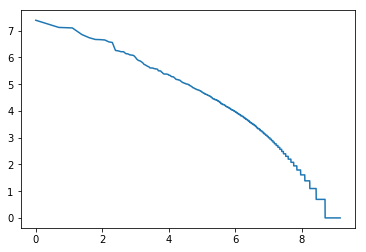

In [19]:
from numpy import log, array
X2= log(array(X))
Y2 = log(array(Y))
plt.plot(X2, Y2)

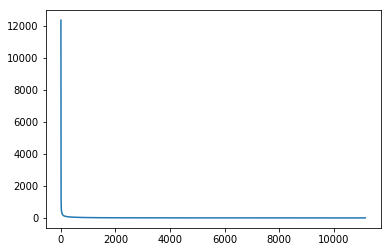

In [20]:
#plt.subplot(312)
list_word = [Token_sorter(word, freq_CACM_NLTK[word]) for word in freq_CACM_NLTK.keys()]
list_word.sort()
X = range(1, len(list_word) + 1)
Y = [word.f for word in list_word]
plt.plot(X, Y)


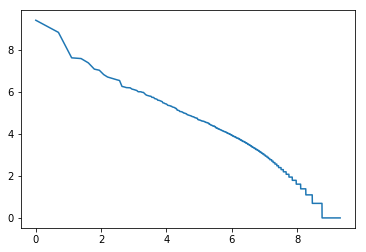

In [21]:
from numpy import log, array
X2= log(array(X))
Y2 = log(array(Y))
plt.plot(X2, Y2)

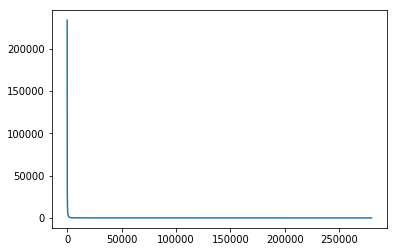

In [22]:
#plt.subplot(313)
list_word = [Token_sorter(word, freq_CS276[word]) for word in freq_CS276.keys()]
list_word.sort()
X = range(1, len(list_word) + 1)
Y = [word.f for word in list_word]
plt.plot(X, Y)

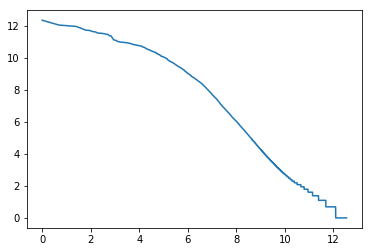

In [23]:
from numpy import log, array
X2= log(array(X))
Y2 = log(array(Y))
plt.plot(X2, Y2)

### INDEX INVERSE

In [24]:
dict_term = {}
i = 0
for token in tokenize_no_nltk_CACM(CACM_documents):
    if token not in dict_term:
        dict_term[token] = i
        i += 1

def write_dict(file_name, liste):
    f = open(file_name, "w")
    for termId, list_docID in liste:
        f.write(str(termId))
        f.write(" ")
        for docID in list_docID:
            f.write(str(docID) + " ")
        f.write("\n")
    f.close()

    
def read_line(line):
    nombres = line.split(' ')
    nombres.pop() #on enlève le \n
    nombres = list(map(int, nombres))
    termID = nombres[0]
    list_docID = nombres[1:]
    return (termID, list_docID)

def add_token_to_term_list(term_list, token, new_list_docID):
    new_termID = dict_term[token]
    for termID, list_docID in term_list:
        if termID == new_termID:
            for docID in new_list_docID:
                if docID not in list_docID:
                    list_docID.append(docID)
            return
    term_list.append((new_termID, list(set(new_list_docID)))) # On enlève les doublons
    

def invert_block(documents, indice_premier, taille):
    tokens = tokenize_no_nltk_CACM(documents[indice_premier:indice_premier + taille])
    index_inverse_block = []
    for token, list_docID in tokens.items():
        add_token_to_term_list(index_inverse_block, token, [docID + indice_premier for docID in list_docID])
    return index_inverse_block

def trouver_terme_mini(liste_lignes):
    minimum = float('inf')
    min_indices = []
    for i in range(len(liste_lignes)):
        if liste_lignes[i] != "":
            termID = read_line(liste_lignes[i])[0]
            if termID < minimum:
                minimum = termID
                min_indices = [i]
            elif termID == minimum:
                min_indices.append(i)
    return min_indices
    

def index_inverse_global(documents, taille, file_name):
    indice = 0
    n = 0
    while indice < len(documents):
        index_inverse_block = invert_block(documents, indice, taille)
        index_inverse_block.sort(key = lambda x: x[0])
        
        write_dict(file_name + "_" + str(n), index_inverse_block)
        n += 1
        indice += taille
    files = [open(file_name + "_" + str(i)) for i in range(n)]
    lignes_courantes = [files[i].readline() for i in range(n)]
    blocks_finis = 0
    final_dict = open(file_name, "w")
    while blocks_finis < n:
        min_indices = trouver_terme_mini(lignes_courantes)
        termID = read_line(lignes_courantes[min_indices[0]])[0]
        docIDs = []
        for i in min_indices:
            docIDs += read_line(lignes_courantes[i])[1]
        final_dict.write(str(termID))
        final_dict.write(" ")
        for docID in docIDs:
            final_dict.write(str(docID) + " ")
        final_dict.write("\n")
        for i in min_indices:
            #print(lignes_courantes)
            #print(min_indices)
            lignes_courantes[i] = files[i].readline()
            #print(lignes_courantes)
            #print()
            if lignes_courantes[i] == '':
                blocks_finis +=1
    [files[i].close() for i in range(n)]
    final_dict.close()
  

In [25]:
index_inverse_global(CACM_documents, 1000, "output")

In [26]:
def write_dict_with_frequency(file_name, liste):
    f = open(file_name, "w")
    for termId, list_docID in liste:
        f.write(str(termId))
        f.write(" ")
        for docID in list_docID:
            f.write(str(docID[0]) + "," + str(docID[1]) + " ")
        f.write("\n")
    f.close()

    
def read_line_with_frequency(line):
    nombres = line.split(' ')
    nombres.pop() #on enlève le \n
    termID = int(nombres[0])
    list_docID = []
    for couple in nombres[1:]:
        docID, freq = map(int, couple.split(","))
        list_docID.append([docID, freq])
    return (termID, list_docID)

def add_token_to_term_list_with_frequency(term_list, token, new_list_docID):
    new_termID = dict_term[token]
    for termID, list_docID in term_list:
        if termID == new_termID:
            for docID in new_list_docID:
                deja_present = False
                for old_docID, freq in list_docID:
                    if docID == old_docID:
                        freq += 1
                        deja_present = True
                        break
                if not deja_present:
                    list_docID.append([doc_ID, 1])
            return
    docID_with_freq = []
    for docID in new_list_docID:
        if docID not in [x[0] for x in docID_with_freq]:
            docID_with_freq.append([docID, new_list_docID.count(docID)])
    term_list.append((new_termID, docID_with_freq)) # On enlève les doublons
    

def invert_block_with_frequency(documents, indice_premier, taille):
    tokens = tokenize_no_nltk_CACM(documents[indice_premier:indice_premier + taille])
    index_inverse_block = []
    for token, list_docID in tokens.items():
        add_token_to_term_list_with_frequency(index_inverse_block, token, [docID + indice_premier for docID in list_docID])
    return index_inverse_block

def trouver_terme_mini_with_frequency(liste_lignes):
    minimum = float('inf')
    min_indices = []
    for i in range(len(liste_lignes)):
        if liste_lignes[i] != "":
            termID = read_line_with_frequency(liste_lignes[i])[0]
            if termID < minimum:
                minimum = termID
                min_indices = [i]
            elif termID == minimum:
                min_indices.append(i)
    return min_indices
    

def index_inverse_global_with_frequency(documents, taille, file_name):
    indice = 0
    n = 0
    while indice < len(documents):
        index_inverse_block = invert_block_with_frequency(documents, indice, taille)
        index_inverse_block.sort(key = lambda x: x[0])
        
        write_dict_with_frequency(file_name + "_" + str(n), index_inverse_block)
        n += 1
        indice += taille
    files = [open(file_name + "_" + str(i)) for i in range(n)]
    lignes_courantes = [files[i].readline() for i in range(n)]
    blocks_finis = 0
    final_dict = open(file_name, "w")
    while blocks_finis < n:
        min_indices = trouver_terme_mini_with_frequency(lignes_courantes)
        termID = read_line_with_frequency(lignes_courantes[min_indices[0]])[0]
        docIDs = []
        for i in min_indices:
            docIDs += read_line_with_frequency(lignes_courantes[i])[1]
        final_dict.write(str(termID))
        final_dict.write(" ")
        for docID in docIDs:
            final_dict.write(str(docID[0]) + "," + str(docID[1]) + " ")
        final_dict.write("\n")
        for i in min_indices:
            lignes_courantes[i] = files[i].readline()
            if lignes_courantes[i] == '':
                blocks_finis +=1
    [files[i].close() for i in range(n)]
    final_dict.close()


In [27]:
index_inverse_global_with_frequency(CACM_documents, 1000, "output frequency")

## Modele booleen

In [28]:
def shunting_yard(query):
    """Transforms an infix query with & | ! into an inverse polish notation"""
    n = len(query)
    i = 0
    output = []
    stack = []
    while i < n:
        if query[i].isalnum():
            mot = ""
            while i < n and query[i].isalnum():
                mot += query[i]
                i += 1
            i -= 1
            output.append(mot)
        elif query[i] in "!&|":
            stack.append(query[i])
        elif query[i] == '(':
            stack.append(query[i])
        elif query[i] == ')':
            while stack[-1]  != '(':
                output.append(stack.pop())
            stack.pop()
        else:
            raise Exception("Problème de parsing")
        i += 1
    while len(stack) > 0:
        output.append(stack.pop())
    
    return output

test = "(a&!b)|(c|terme)"
print(shunting_yard(test))

def find_documents_from_term(term):
    """
    return the documents containing term from inversed index
    """
    if term not in dict_term:
        return set()
    else:
        termID = dict_term[term]
        with open("output") as f:
            lines = f.readlines()
        for line in lines:
            splited_line = line.strip().split(" ")
            if splited_line[0] == str(termID):
                # print(set(splited_line[1:]))
                return set(splited_line[1:])
    

stop_list = read_forbidden_words()

def find_documents(polish_notation):
    stack = []
    all_docs = set(range(len(CACM_documents)))
    for token in polish_notation:
        if token.isalpha():
            if token.lower() in stop_list:
                stack.append("stop")
            else:
                stack.append(find_documents_from_term(token.lower()))
        elif token == "|":
            value1 = stack.pop()
            value2 = stack.pop()
            if value1 == "stop":
                stack.append(value2)
            elif value2 == "stop":
                stack.append(value1)
            else:
                stack.append(value1 | value2)
        elif token == "&":
            value1 = stack.pop()
            value2 = stack.pop()
            if value1 == "stop":
                stack.append(value2)
            elif value2 == "stop":
                stack.append(value1)
            else:
                stack.append(value1 & value2)
        elif token == "!":
            value = stack.pop()
            if value == "stop":
                stack.append("stop")
            else:
                stack.append(all_docs - value)
    
    return stack.pop()

def boolean_model(query):
    polish_notation = shunting_yard(query)
    return find_documents(polish_notation)


['a', 'b', '!', '&', 'c', 'terme', '|', '|']


In [29]:
from time import time
debut = time()
boolean_model("Algebraic&Language|(Preliminary&printer)")
print(time() - debut)
# puis récupérer le document avec CACM_documents

0.01900339126586914


In [30]:
#Vectoriel

def get_list_term_id_from_request(request):
    forbidden_words = read_forbidden_words()
    list_term_id = []
    if len(request) > 0:
        tokens = re.compile("[^0-9a-zA-Z]").split(request)
        for token in tokens:
            if token.lower() not in forbidden_words and len(token) > 0:
                if token.lower() not in d:
                    list_term_id.append(dict_term[token.lower()])
    return list_term_id

def get_dft_list(inverse_index_filename):
    with open(inverse_index_filename) as f:
        dft = []
        for line in f.readlines():
            splitted_line = line.split()
            frequency = len(splitted_line) - 1
            dft.append(frequency)
    return get_dft_list

def get_posting_lists(term_ID_list, inverse_index_filename):
    with open(inverse_index_filename) as f:
        posting_lists = {}
        for line in f.readlines():
            splitted_line = line.split()
            term_id = int(splitted_line[0])
            if term_id in term_ID_list:
                posting_list = {}
                for k in range(1, len(splitted_line)):
                    doc_id, freq = map(int, splitted_line[k].split(","))
                    posting_list[doc_id] = freq
                posting_lists[term_id] = posting_list
    return posting_lists

def get_document_list_from_postig_lists(posting_lists):
    docs = set()
    for posting_list in posting_lists:
        for d in posting_list.keys():
            docs.add(d)
    return list(docs)

def w(t, d, posting_lists, dfts, N):
    if d in posting_lists[t]:
        tftd = posting_lists[t][d]
    else:
        return 0
    dft = dfts[t]
    return (1+log(tftd, 10)) * log(N/dtf, 10)

def vectorize_request(list_term_id, N, dfts):
    vector_request = []
    for term_id in list_term_id:
        vector.request.append(log(N/dfts[t], 10))
    return vector_request

def vectorize_document(doc_id, list_term_id, N, dfts, posting_lists):
    vector_doc = []
    for term in list_term_id:
        vector_doc.append(w(term, doc_id, posting_lists, dfts, N))
    return vector_doc

from math import sqrt

def find_nearest_cosinus_vector(vector_request, vector_doc_list):
    minimum = float('inf')
    minimum_ind = 0
    for vector_doc in vector_doc_list:
        produit_scalaire = 0
        norme_1 = 0
        norme_2 = 0
        for i in range(len(vector_request)):
            produit_scalaire += vector_request[i] * vector_doc[i]
            norme_1 += vector_request[i]**2
            norme_2 += vector_doc[i]**2
        mesure = produit_scalaire / (sqrt(norme_1) * sqrt(norme_2))
        if mesure <= minimum:
            minimum = mesure
            minimum_ind = i
    return vector_doc_list[minimum_ind]

def modele_vectoriel(request):
    docs = CACM_documents
    N = len(CACM_documents)
    inverse_index_filename = "output frequency"
    dfts = get_dft_list(inverse_index_filename)
    
    list_term_id = get_list_term_id_from_request(request)
    posting_lists = get_posting_lists(list_term_id, inverse_index_filename)
    docs = get_document_list_from_postig_lists(posting_lists)
    
    vector_doc_list = []
    for doc in docs:
        vector_doc_list.append(vectorize_document(doc, list_term_id, N, dfts, posting_lists))
    
    vector_request = vectorize_request(list_term_id, N, dfts)
    
    best_vector_docs = []
    
    while len(vector_doc_list) > 0:
        best_doc = find_nearest_cosinus_vector(vector_request, vector_doc_list)
        best_vector_docs.append(best_doc)
        vector_doc_list.remove(best_doc)
    
    return best_vector_docs
    
    
                    
    